In [27]:
import pandas
import sqlalchemy
from matplotlib import pyplot
import seaborn
import sklearn
import warnings

%matplotlib inline

In [28]:
warnings.filterwarnings("ignore")

In [29]:
con = sqlalchemy.create_engine("""sqlite:////Users/noname/Desktop/tester.db""")
data = pandas.read_sql_query("""SELECT * FROM zaif_ticker""", con )
del data["currency_pair"]

In [30]:
data.index = pandas.to_datetime(data.date)

In [31]:
data.tail(10)

,index,amount,currenty_pair,date,price,tid,trade_type
date,,,,,,,
2017-07-05 09:24:21,0,0.0100,btc_jpy,2017-07-05 09:24:21.000000,292500.0,57539964,ask
2017-07-05 09:24:21,1,0.0826,btc_jpy,2017-07-05 09:24:21.000000,292500.0,57539963,ask
2017-07-05 09:24:23,0,0.0100,btc_jpy,2017-07-05 09:24:23.000000,292500.0,57539965,ask
2017-07-05 09:24:26,0,0.0100,btc_jpy,2017-07-05 09:24:26.000000,292500.0,57539967,ask
2017-07-05 09:24:26,1,0.0626,btc_jpy,2017-07-05 09:24:26.000000,292500.0,57539966,ask
2017-07-05 09:24:34,0,0.0201,btc_jpy,2017-07-05 09:24:34.000000,292500.0,57539969,ask
2017-07-05 09:24:33,1,0.0100,btc_jpy,2017-07-05 09:24:33.000000,292500.0,57539968,ask
2017-07-05 09:24:36,0,0.0206,btc_jpy,2017-07-05 09:24:36.000000,292555.0,57539971,bid
2017-07-05 09:24:36,1,0.0426,btc_jpy,2017-07-05 09:24:36.000000,292500.0,57539970,ask


In [32]:
bid_data = data[data.trade_type == "bid"]
ask_data = data[data.trade_type == "ask"]

bid_resampled = bid_data.resample("10s").mean().dropna()
ask_resampled = ask_data.resample("10s").mean().dropna()

In [33]:
bid_resampled.head()

,index,amount,price,tid
date,,,,
2017-07-02 03:07:00,20.0,0.0068,279655.000000,57229992.0
2017-07-02 03:07:20,19.0,0.0317,279620.000000,57229993.0
2017-07-02 03:07:40,13.0,0.0051,279631.666667,57230002.0
2017-07-02 03:07:50,6.0,0.0158,279635.000000,57230010.0
2017-07-02 03:08:50,0.0,0.0183,279725.000000,57230018.0


In [8]:
ask_resampled.head()

,index,amount,price,tid
date,,,,
2017-07-02 03:07:20,18.0,0.0035,279570.0,57229997.0
2017-07-02 03:07:30,17.0,0.0035,279555.0,57229998.0
2017-07-02 03:07:40,11.5,0.0101,279552.5,57230003.5
2017-07-02 03:07:50,6.0,0.0035,279600.0,57230010.0
2017-07-02 03:08:00,4.0,0.0183,279580.0,57230012.0


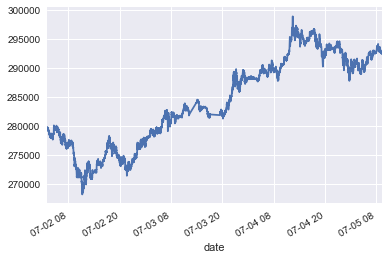

In [9]:
bid_resampled["price"].plot()

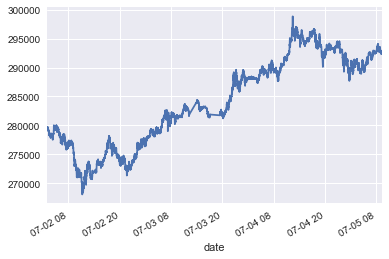

In [10]:
ask_resampled["price"].plot()

In [11]:
price_data  = pandas.concat([bid_resampled["price"], ask_resampled["price"]],axis=1)
price_data.columns = ["bid", "ask"]

spread = price_data["bid"] - price_data["ask"]

spread.describe()

count    18234.000000
mean        47.131411
std         70.897591
min       -477.692308
25%          5.000000
50%         25.833333
75%         71.795093
max       1320.108696
dtype: float64

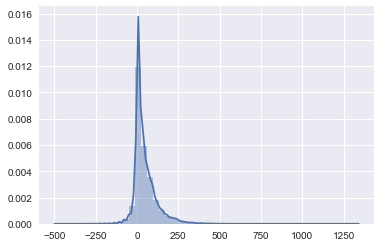

In [12]:
seaborn.distplot(spread.dropna())

In [25]:
out = spread.dropna()[spread.dropna() < 250][spread.dropna() > -250]

((array([-3.95170353, -3.73414592, -3.61503959, ...,  3.61503959,
          3.73414592,  3.95170353]),
  array([-242.95454545, -234.91421569, -228.30357143, ...,  248.625     ,
          249.33333333,  249.5       ])),
 (53.814523555017075, 41.394996388691538, 0.95116174862724479))

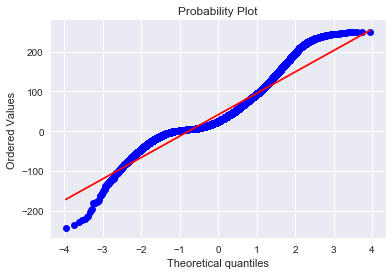

In [26]:
import scipy.stats as stats
import pylab
stats.probplot(out, dist="norm", plot=pylab)

In [15]:
stats.shapiro(out)

(0.8319584131240845, 0.0)

In [16]:
stats.shapiro(spread.dropna())

(0.8145678043365479, 0.0)

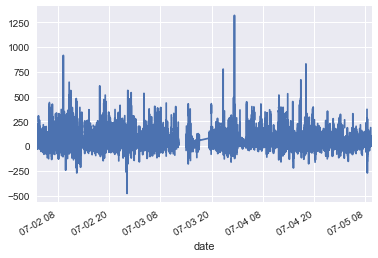

In [17]:
spread.plot()

# 全データ使う

In [18]:
resampled = data.resample("10s").mean().dropna()

In [19]:
# dataset Creation
training_data = resampled["2017-07-02 06:30:00":]
#test_data = resampled["2017-07-02 06:30:00":]

In [20]:
test_data["price"].plot()

NameError: name 'test_data' is not defined

In [ ]:
training_data["price"].plot()

In [ ]:
rolling_diff_1M = training_data.rolling(6).mean()["price"].diff().dropna()
rolling_diff_5M = training_data.rolling(30).mean()["price"].diff().dropna()
rolling_diff_10M = training_data.rolling(60).mean()["price"].diff().dropna()

In [ ]:
rolling_diff_df = pandas.concat([rolling_diff_1M, rolling_diff_5M, rolling_diff_10M], axis=1).dropna()
rolling_diff_df.columns = ["1M", "5M", "10M"]

In [ ]:
rolling_diff_df.plot()

In [ ]:
rolling_1M = training_data.rolling(6).mean()["price"].dropna()
rolling_5M = training_data.rolling(30).mean()["price"].dropna()
rolling_10M = training_data.rolling(360).mean()["price"].dropna()

rolling_df = pandas.concat([rolling_1M, rolling_5M, rolling_10M], axis=1).dropna()
rolling_df.columns = ["1M", "5M", "10M"]

rolling_df.plot()

In [ ]:
# Detect Golden Cross / Dead Cross
def golden_detect(latest_3_df: pandas.DataFrame) -> bool:
    """
    >>> df = {'10M': {Timestamp('2017-06-30 16:35:20'): 282846.5542856449,
  Timestamp('2017-06-30 16:35:30'): 282849.31539675605,
  Timestamp('2017-06-30 16:35:40'): 282849.89873008936},
 '1M': {Timestamp('2017-06-30 16:35:20'): 282971.85019841272,
  Timestamp('2017-06-30 16:35:30'): 282930.29464285716,
  Timestamp('2017-06-30 16:35:40'): 282899.52083333331},
 '5M': {Timestamp('2017-06-30 16:35:20'): 282863.28952367074,
  Timestamp('2017-06-30 16:35:30'): 282869.81174589298,
  Timestamp('2017-06-30 16:35:40'): 282871.70222208346}}
    >>> df = pandas.DataFrame.from_dict(df)
    >>> golden_detect(df)
  """
    